In [10]:
import sys
print(sys.executable)
#python -m pip install torch torchvision torchaudio numpy matplotlib tqdm--force-reinstall --no-cache-dir
#python -m pip install numpy matplotlib tqdm --force-reinstall --no-cache-dir

C:\Users\jzl0375\.conda\envs\diffusion\python.exe


In [21]:
!{sys.executable} -m pip install einops

In [56]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from diffuser.temporal_cond import ConditionalTemporalUnet
from diffuser.diffusion_cond import GaussianDiffusion


In [42]:
# =========================================================
# 1️⃣ Synthetic Moving-Dot Trajectory 생성
# =========================================================
def generate_team_trajectories(batch_size=8, horizon=100, n_players=23):
    t = torch.linspace(0, 2*np.pi, horizon)[None, :, None]
    base_motion = torch.cat([torch.sin(t), torch.cos(t)], dim=-1)  # [1, horizon, 2]

    # 각 플레이어마다 phase shift
    player_phase = torch.rand(n_players, 1, 1) * 2 * np.pi
    player_motion = base_motion.repeat(n_players, 1, 1) + 0.2 * torch.sin(t + player_phase)

    x = player_motion.permute(1, 0, 2).unsqueeze(0)  # [1, horizon, n_players, 2]
    return x.repeat(batch_size, 1, 1, 1)

In [53]:
# =========================================================
# 2️⃣ 설정
# =========================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 4
horizon = 100

n_teamA = 11   # 공격팀
n_teamB = 11   # 수비팀
n_ball = 1
n_players = n_teamA + n_teamB + n_ball  # 총 23 객체
feature_dim = n_players * 2  # (x, y)
timesteps = 200  # diffusion step 수
observed_frames = 40  # optional: 초반 conditioning frame 수

# =========================================================
# 3️⃣ 샘플 데이터 생성
# =========================================================
x_data = generate_team_trajectories(batch_size, horizon, n_players)
x_data = x_data.reshape(batch_size, horizon, feature_dim)  # [batch, T, 46]

# 인덱스 기준
full_condition_idx = torch.arange(0, feature_dim)
partial_condition_idx = torch.cat([
    torch.arange(0, n_teamA * 2),                    # 공격팀
    torch.arange((n_teamA + n_teamB) * 2, feature_dim)  # 공
])

conditions = {}
for t in range(horizon):
    if t < observed_frames:
        conditions[t] = x_data[:, t, full_condition_idx].clone()
    else:
        conditions[t] = x_data[:, t, partial_condition_idx].clone()

In [59]:
x_data

tensor([[[ 0.0359,  1.0359,  0.0738,  ...,  1.1799,  0.1728,  1.1728],
         [ 0.1117,  1.0463,  0.1253,  ...,  1.1831,  0.2294,  1.1640],
         [ 0.1871,  1.0525,  0.1763,  ...,  1.1815,  0.2852,  1.1506],
         ...,
         [-0.1159,  1.0026, -0.0299,  ...,  1.1593,  0.0575,  1.1761],
         [-0.0401,  1.0213,  0.0220,  ...,  1.1720,  0.1154,  1.1768],
         [ 0.0359,  1.0359,  0.0738,  ...,  1.1799,  0.1728,  1.1728]],

        [[ 0.0359,  1.0359,  0.0738,  ...,  1.1799,  0.1728,  1.1728],
         [ 0.1117,  1.0463,  0.1253,  ...,  1.1831,  0.2294,  1.1640],
         [ 0.1871,  1.0525,  0.1763,  ...,  1.1815,  0.2852,  1.1506],
         ...,
         [-0.1159,  1.0026, -0.0299,  ...,  1.1593,  0.0575,  1.1761],
         [-0.0401,  1.0213,  0.0220,  ...,  1.1720,  0.1154,  1.1768],
         [ 0.0359,  1.0359,  0.0738,  ...,  1.1799,  0.1728,  1.1728]],

        [[ 0.0359,  1.0359,  0.0738,  ...,  1.1799,  0.1728,  1.1728],
         [ 0.1117,  1.0463,  0.1253,  ...,  1

🎥 Visualizing play #0 | shape = torch.Size([100, 46])


C:\Users\jzl0375\AppData\Local\Temp\ipykernel_40196\1995049511.py:57: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  ani = FuncAnimation(fig, update_anim, frames=horizon,


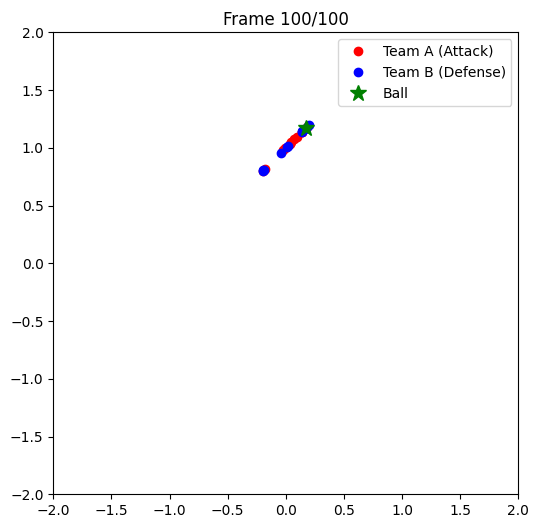

In [58]:
from IPython.display import HTML
# =========================================================
# (1) 한 배치 선택
# =========================================================
batch_idx = 0  # 시각화할 플레이 인덱스 (0 ~ batch_size-1)
gt = x_data[batch_idx]  # [horizon, feature_dim]
print(f"🎥 Visualizing play #{batch_idx} | shape = {gt.shape}")

# =========================================================
# (2) 기본 시각화 설정
# =========================================================
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title("⚽ Synthetic Soccer Trajectories")

# 팀 색상 및 마커 설정
teamA_color = 'red'     # 공격팀
teamB_color = 'blue'    # 수비팀
ball_color = 'green'    # 공

attackers, = ax.plot([], [], 'o', color=teamA_color, label='Team A (Attack)')
defenders, = ax.plot([], [], 'o', color=teamB_color, label='Team B (Defense)')
ball, = ax.plot([], [], '*', color=ball_color, markersize=12, label='Ball')
ax.legend()

# =========================================================
# (3) 초기화 함수
# =========================================================
def init_anim():
    attackers.set_data([], [])
    defenders.set_data([], [])
    ball.set_data([], [])
    return attackers, defenders, ball

# =========================================================
# (4) 프레임 업데이트 함수
# =========================================================
def update_anim(frame):
    data = gt[frame].reshape(n_players, 2)

    teamA_xy = data[:n_teamA]
    teamB_xy = data[n_teamA:n_teamA + n_teamB]
    ball_xy = data[-1]

    # 좌표 설정 (x, y는 리스트로 전달해야 함)
    attackers.set_data(teamA_xy[:, 0], teamA_xy[:, 1])
    defenders.set_data(teamB_xy[:, 0], teamB_xy[:, 1])
    ball.set_data([ball_xy[0].item()], [ball_xy[1].item()]) 

    ax.set_title(f"Frame {frame + 1}/{horizon}")
    return attackers, defenders, ball

# =========================================================
# (5) 애니메이션 생성
# =========================================================
ani = FuncAnimation(fig, update_anim, frames=horizon,
                    init_func=init_anim, interval=150, blit=True)

HTML(ani.to_jshtml())

▶️ Showing sample dataset trajectories...


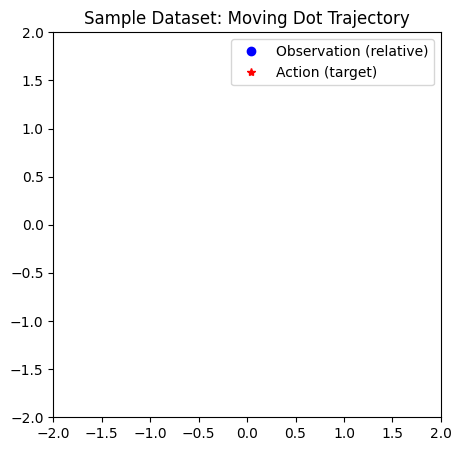


Initializing diffusion model...


TypeError: slice indices must be integers or None or have an __index__ method

In [35]:
# =========================================================
# 5️⃣ 모델 정의
# =========================================================
print("\nInitializing diffusion model...")
unet = ConditionalTemporalUnet(
    horizon=horizon,
    transition_dim=transition_dim,
    dim=32,
    dim_mults=(1, 2, 4),
    attention=True
).to(device)

diffusion = GaussianDiffusion(
    model=unet,
    horizon=horizon,
    observation_dim=obs_dim,
    action_dim=action_dim,
    n_timesteps=timesteps,
    loss_type='l1',
    clip_denoised=True,
    predict_epsilon=True,
    action_weight=1.0,
    loss_discount=0.98,
    device=device
).to(device)

# =========================================================
# 6️⃣ 간단한 학습 루프
# =========================================================
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
x_train = x_data.to(device)
for epoch in range(3):
    optimizer.zero_grad()
    loss, info = diffusion.loss(x_train, conditions)
    loss.backward()
    optimizer.step()
    print(f"[Epoch {epoch+1}] Loss: {loss.item():.6f}")

# =========================================================
# 7️⃣ 샘플링 (예측)
# =========================================================
print("\nSampling predicted trajectory...")
sample = diffusion.conditional_sample(conditions, horizon=horizon, verbose=False)
x_pred = sample.trajectories.detach().cpu()
pred = x_pred[0]

# =========================================================
# 8️⃣ 예측 결과 시각화 (움직이는 dot)
# =========================================================
fig2, ax2 = plt.subplots(figsize=(5, 5))
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_title("Predicted vs Ground Truth Moving Dot")
obs_dot, = ax2.plot([], [], 'bo', label='Observed')
gt_dot, = ax2.plot([], [], 'go', label='Ground Truth')
pred_dot, = ax2.plot([], [], 'r*', label='Predicted')
ax2.legend()

def init_pred():
    obs_dot.set_data([], [])
    gt_dot.set_data([], [])
    pred_dot.set_data([], [])
    return obs_dot, gt_dot, pred_dot

def update_pred(frame):
    if frame < observed_frames:
        obs_dot.set_data(gt[frame, 4], gt[frame, 5])
        gt_dot.set_data([], [])
        pred_dot.set_data([], [])
    else:
        obs_dot.set_data(gt[observed_frames-1, 4], gt[observed_frames-1, 5])
        gt_dot.set_data(gt[frame, 4], gt[frame, 5])
        pred_dot.set_data(pred[frame, 4], pred[frame, 5])
    return obs_dot, gt_dot, pred_dot

ani2 = FuncAnimation(fig2, update_pred, frames=horizon,
                     init_func=init_pred, interval=150, blit=True)
plt.show()
